In [1]:
import cv2
import numpy as np
import os
import glob
import mahotas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
# Extract Features

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(0)
    return haralick

def fd_histogram(image, bins=8):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [3]:
dataset_path = "Labelled"
fixed_size = (300, 300)
bins = 8

In [4]:
global_features = []
labels = []

In [5]:
train_labels = os.listdir(dataset_path)
train_labels.sort()

In [6]:
for training_name in train_labels:
    dir = os.path.join(dataset_path, training_name)
    current_label = training_name
    
    file_list = glob.glob(os.path.join(dir, "*"))
    
    for file in file_list:
        image = cv2.imread(file)
        if image is None: continue
        
        image = cv2.resize(image, fixed_size)

        # Extract
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image, bins)

        # Combine
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        labels.append(current_label)
        global_features.append(global_feature)

In [7]:
le = LabelEncoder()
target = le.fit_transform(labels)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    rescaled_features, target, test_size=0.3, random_state=42, stratify=target
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [10]:
num_classes = len(train_labels)
y_train_hot = to_categorical(y_train, num_classes)
y_val_hot   = to_categorical(y_val, num_classes)
y_test_hot  = to_categorical(y_test, num_classes)

In [11]:
model = Sequential()
input_dim = rescaled_features.shape[1]

model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\Asus TUF\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(
    X_train, y_train_hot,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_hot),
    verbose=1
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6260 - loss: 0.9323 - val_accuracy: 0.8475 - val_loss: 0.3666
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8470 - loss: 0.3654 - val_accuracy: 0.8715 - val_loss: 0.3153
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8594 - loss: 0.3166 - val_accuracy: 0.8689 - val_loss: 0.2899
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.2901 - val_accuracy: 0.8724 - val_loss: 0.2903
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8670 - loss: 0.2959 - val_accuracy: 0.8742 - val_loss: 0.2826
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8923 - loss: 0.2629 - val_accuracy: 0.8769 - val_loss: 0.2786
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8889 - loss: 0.2730 - val_accuracy: 0.8715 - val_loss: 0.2840
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8900 - loss: 0.2649 - val_accuracy: 0.

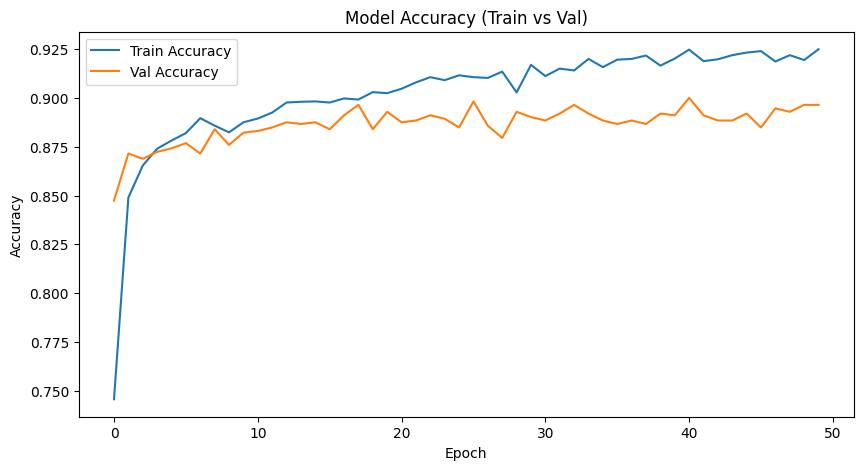

In [16]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Train vs Val)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
results = model.evaluate(X_test, y_test_hot, batch_size=32)
print(f"\nTest Loss     : {results[0]:.4f}")
print(f"Test Accuracy : {results[1]*100:.2f}%")

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2729 

Test Loss     : 0.2748
Test Accuracy : 89.66%


In [15]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_hot, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [17]:
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       241
      BrownSpot       0.96      0.93      0.94       322
        Healthy       0.72      0.87      0.79       223
      LeafBlast       0.64      0.44      0.53       117
       Leafsmut       1.00      1.00      1.00       219

       accuracy                           0.90      1122
      macro avg       0.87      0.85      0.85      1122
   weighted avg       0.90      0.90      0.89      1122



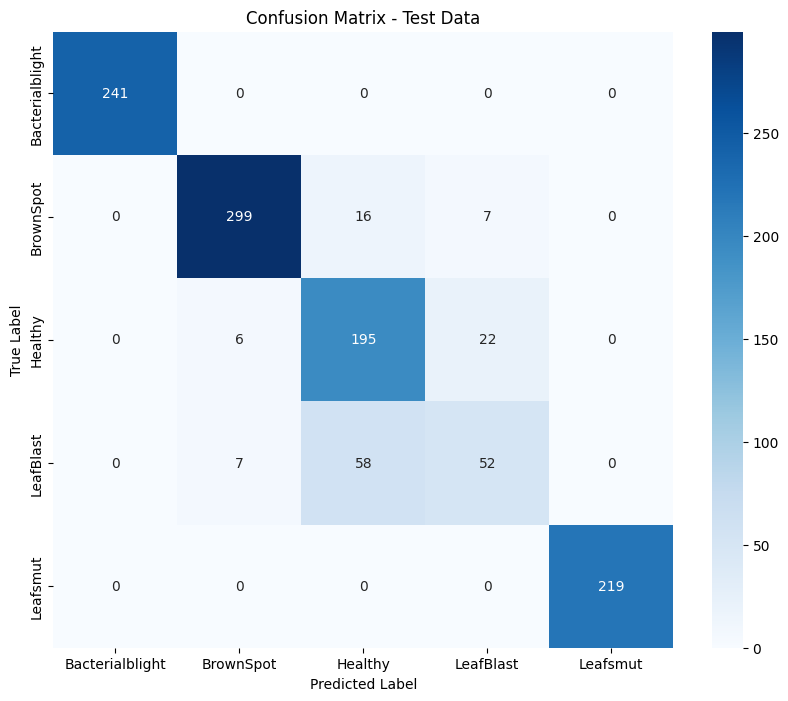

In [18]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()